#Brain Tumor Detection Model using MRI Images Model

#Uploading the dataset using Kaggle API
Dataset Used --> masoudnickparvar/brain-tumor-mri-dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dishamittalnitb","key":"1c67e45799f853c856a6b441530926d7"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!pip install -q kaggle

In [4]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


#Import Libraries

In [5]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

#Load Dataset

In [6]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

#Data Visualization


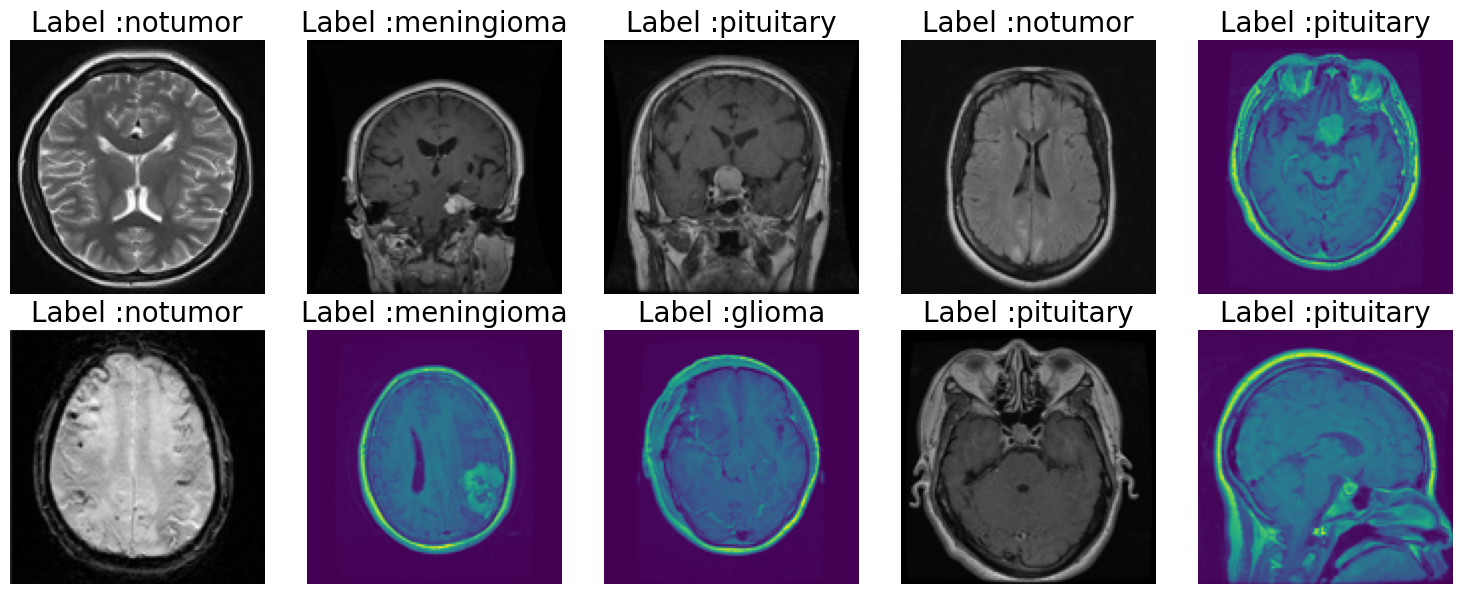

In [7]:
import random
import matplotlib.pyplot as plt

#Select Random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

#Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

#Loop through the random indices and display images
for i, index in enumerate(random_indices):
    image_path = train_paths[index]
    image = Image.open(image_path)
    image= image.resize((128, 128))

    #Display images
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Label :{train_labels[index]}",fontsize=20)

plt.tight_layout()
plt.show()

#Image Preprocessing (Helper Function)

In [35]:
#Image Augmentation Function
def augment_image(image):
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))    # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

#Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
      image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
      image = augment_image(image)
      images.append(image)
  return np.array(images)

#Encoder labels (Convert label names to integers)
from sklearn.preprocessing import LabelEncoder
unique_labels = sorted(os.listdir(train_dir))
le = LabelEncoder()
le.fit(unique_labels)  # Save globally

def encode_label(labels):
    return le.transform(labels)

#Data generator for batching
def datagen(paths,labels,batch_size=12, epochs = 1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

#Trasfer Learning and Model Architecture

In [36]:
from operator import mod
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

#Freeze all layers of the VGG16 based model
for layer in base_model.layers:
  layer.trainable = False

#Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#Build Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model) #VG16 model
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

#Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics =['sparse_categorical_accuracy'])

#Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.7329
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.2443 - sparse_categorical_accuracy: 0.9075
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.9444
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.9536
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9611


#Model Training Plot

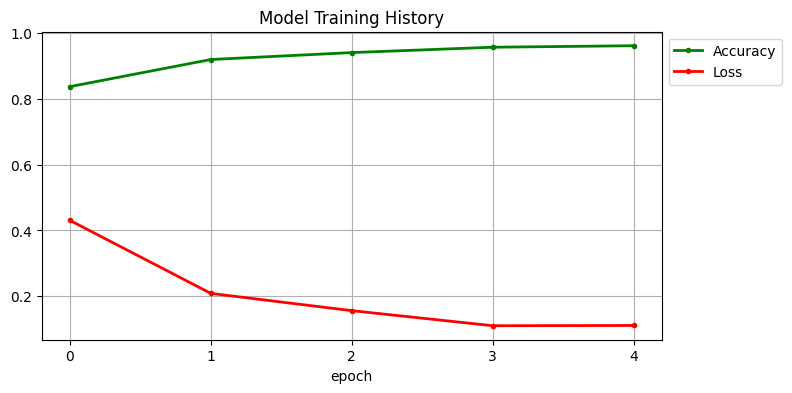

In [10]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model classification report

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       300
           1       0.80      0.94      0.87       306
           2       0.99      0.99      0.99       405
           3       0.92      0.99      0.95       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



#Model Confusion Plot

Confusion Matrix:
[[223  65   2  10]
 [  0 287   2  17]
 [  0   3 402   0]
 [  0   2   0 298]]


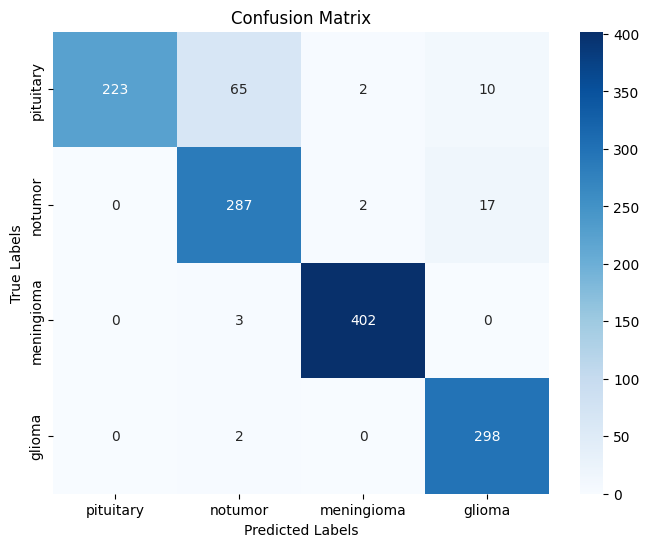

In [38]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

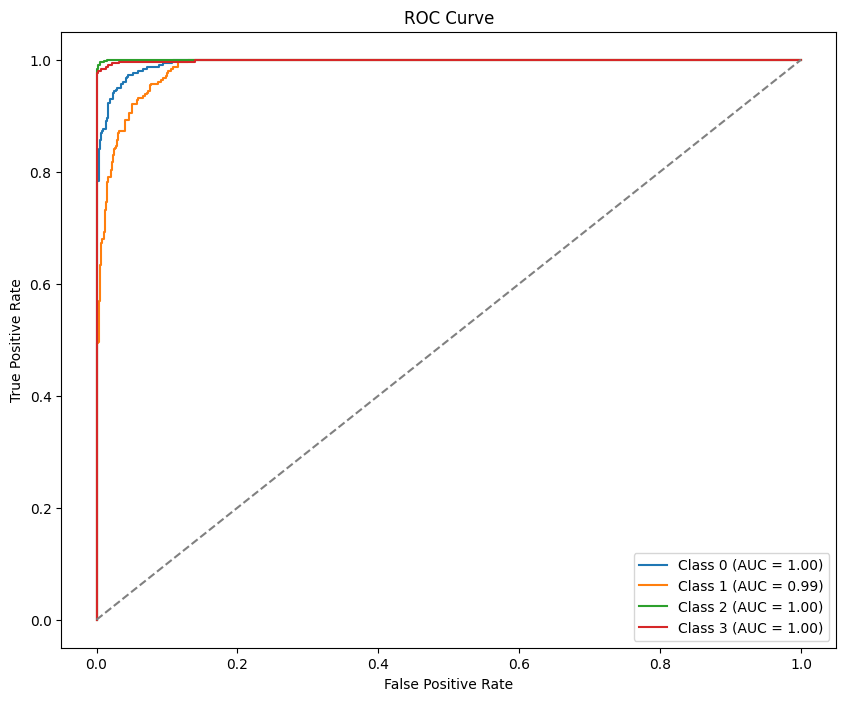

In [39]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

#Saving The Model

In [53]:
model.save('my_model.keras')

In [52]:
model = load_model('my_model.keras')


#Model Implementation

In [58]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = [ 'Glioma','Meningioma', 'Notumor', 'Pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'Notumor':
            result = f"No Tumor:"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

#Example Test Cases

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


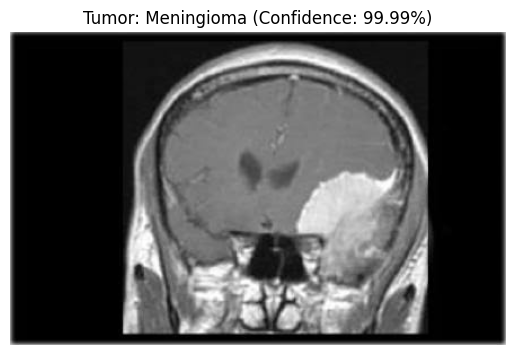

In [59]:
# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


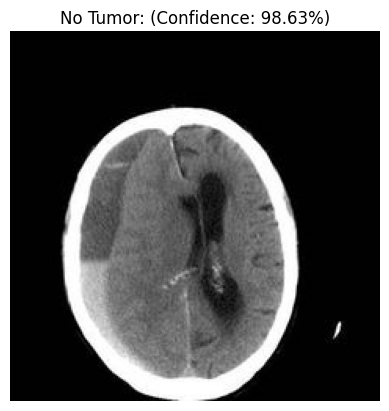

In [60]:
# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


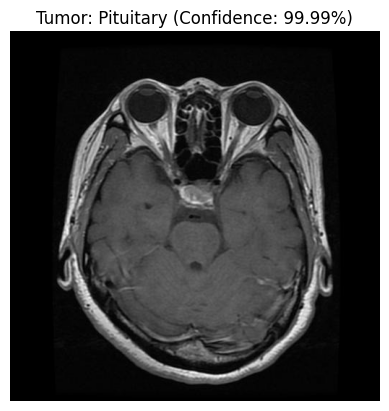

In [61]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-piTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


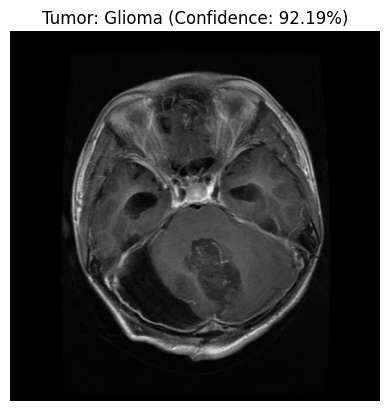

In [62]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)